# MasterCard Fraud

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import plotly
import plotly.express as px

In [5]:
# read in data
df = pd.read_csv('data/fraudTrain.csv')

In [6]:
df = df.iloc[: , 1:]
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Exploration of data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [8]:
df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

### Correlation

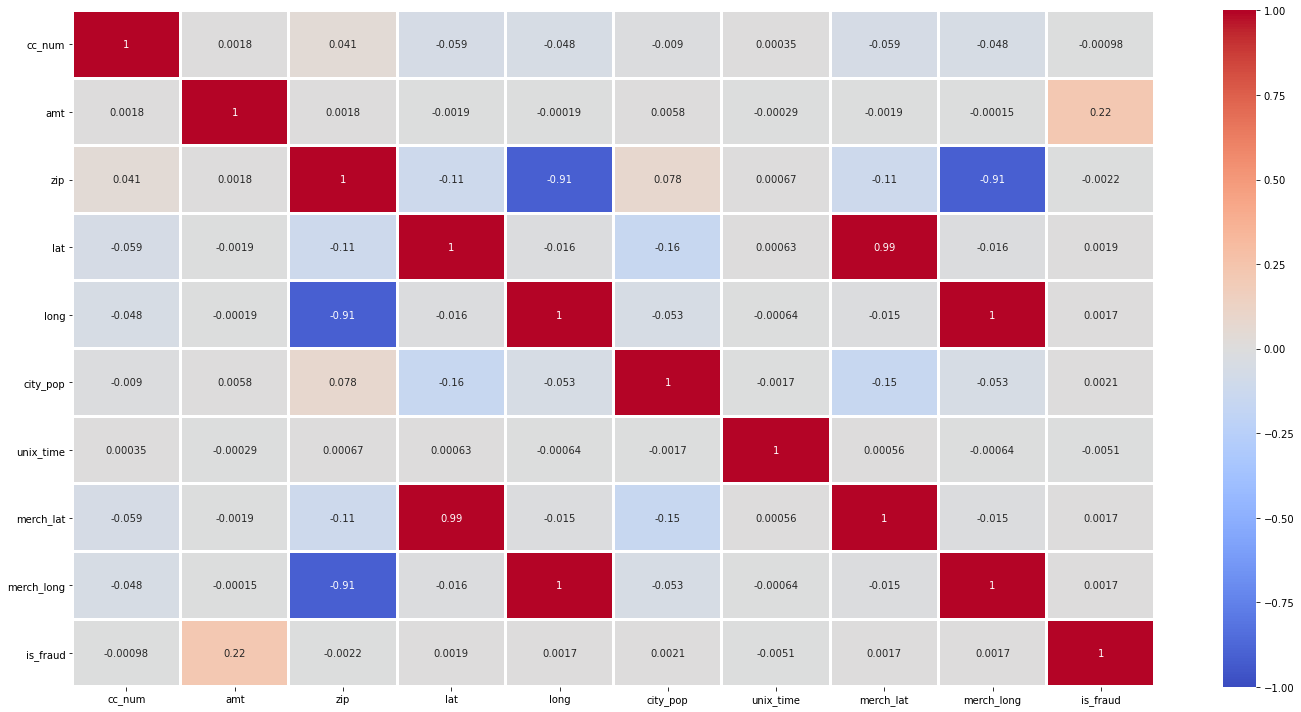

In [9]:
# plot heatmap of all features to view correlation
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1,vmax=1,
           annot=True, linewidths=2)
plt.tight_layout()
plt.show()

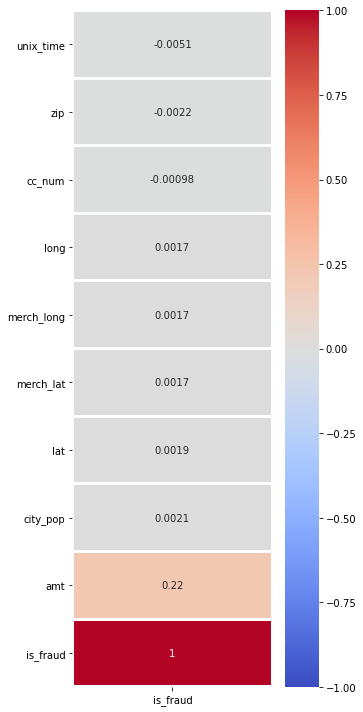

In [10]:
# plot heatmap with just the target variable
plt.figure(figsize=(5,10))
sns.heatmap(df.corr()[['is_fraud']].sort_values(by=['is_fraud']), cmap='coolwarm', vmin=-1,vmax=1,
           annot=True, linewidths=2)
plt.tight_layout()
plt.show()

In [11]:
# sns.pairplot(df)

In [12]:
df['merchant']

0                   fraud_Rippin, Kub and Mann
1              fraud_Heller, Gutmann and Zieme
2                         fraud_Lind-Buckridge
3           fraud_Kutch, Hermiston and Farrell
4                          fraud_Keeling-Crist
                          ...                 
1296670                      fraud_Reichel Inc
1296671               fraud_Abernathy and Sons
1296672                   fraud_Stiedemann Ltd
1296673    fraud_Reinger, Weissnat and Strosin
1296674    fraud_Langosh, Wintheiser and Hyatt
Name: merchant, Length: 1296675, dtype: object

I want to replace get rid of commas and fraud_ fromt the merchant column:

In [13]:
df['merchant'] = df['merchant'].str.replace('fraud_', '').str.replace(',', '').str.replace(' ','_')

In [14]:
df['merchant']

0                   Rippin_Kub_and_Mann
1              Heller_Gutmann_and_Zieme
2                        Lind-Buckridge
3           Kutch_Hermiston_and_Farrell
4                         Keeling-Crist
                       ...             
1296670                     Reichel_Inc
1296671              Abernathy_and_Sons
1296672                  Stiedemann_Ltd
1296673    Reinger_Weissnat_and_Strosin
1296674    Langosh_Wintheiser_and_Hyatt
Name: merchant, Length: 1296675, dtype: object

In [15]:
df['merchant'].nunique()

693

In [16]:
df['merchant'].value_counts()

Kilback_LLC                      4403
Cormier_LLC                      3649
Schumm_PLC                       3634
Kuhn_LLC                         3510
Boyer_PLC                        3493
                                 ... 
Douglas_DuBuque_and_McKenzie      775
Treutel-King                      775
Medhurst_Labadie_and_Gottlieb     759
Reichert-Weissnat                 753
Hahn_Douglas_and_Schowalter       727
Name: merchant, Length: 693, dtype: int64

In [17]:
merchant_values = df['merchant'].value_counts()/len(df)*100
merchant_values

Kilback_LLC                      0.339561
Cormier_LLC                      0.281412
Schumm_PLC                       0.280255
Kuhn_LLC                         0.270692
Boyer_PLC                        0.269381
                                   ...   
Douglas_DuBuque_and_McKenzie     0.059768
Treutel-King                     0.059768
Medhurst_Labadie_and_Gottlieb    0.058534
Reichert-Weissnat                0.058072
Hahn_Douglas_and_Schowalter      0.056066
Name: merchant, Length: 693, dtype: float64

In [18]:
threshold_merchant = 0.2

imp_merchant = merchant_values[merchant_values > threshold_merchant]
imp_merchant

Kilback_LLC                             0.339561
Cormier_LLC                             0.281412
Schumm_PLC                              0.280255
Kuhn_LLC                                0.270692
Boyer_PLC                               0.269381
Dickinson_Ltd                           0.264831
Cummerata-Jones                         0.211001
Kutch_LLC                               0.210847
Olson_Becker_and_Koch                   0.209999
Stroman_Hudson_and_Erdman               0.209844
Rodriguez_Group                         0.209459
Erdman-Kertzmann                        0.208610
Jenkins_Hauck_and_Friesen               0.208610
Kling_Inc                               0.207222
Connelly_Reichert_and_Fritsch           0.206991
Friesen-Stamm                           0.206682
Prohaska-Murray                         0.206605
Huels-Hahn                              0.206528
Berge_LLC                               0.206451
Bartoletti-Wunsch                       0.206374
Christiansen_Goyette

In [19]:
imp_merchant.nunique()

41

In [20]:
df['merchant'] = np.where(df['merchant'].isin(imp_merchant.index), df['merchant'], 'other')

In [21]:
df['merchant'].nunique()

44

In [22]:
# apply other using lambda
df['merchant'].apply(lambda x: 'other' if x not in imp_merchant.index else x)

0                                other
1                                other
2                                other
3          Kutch_Hermiston_and_Farrell
4                                other
                      ...             
1296670                          other
1296671                          other
1296672                          other
1296673                          other
1296674                          other
Name: merchant, Length: 1296675, dtype: object

View 'category' column

In [23]:
df['category'].value_counts()

gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: category, dtype: int64

Since there seems to be some additional features in the category column, I think I can extract them and create new features.

I will first create a new_category feature that simplifies the categories and gets rid of 'pos' or 'net' from the category.

In [24]:
df['new_category'] = df['category']

In [25]:
df.loc[df['category'] == 'grocery_pos', 'new_category'] = 'grocery'
df.loc[df['category'] == 'shopping_pos', 'new_category'] = 'shopping'
df.loc[df['category'] == 'shopping_net', 'new_category'] = 'shopping'
df.loc[df['category'] == 'misc_pos', 'new_category'] = 'misc'
df.loc[df['category'] == 'misc_net', 'new_category'] = 'misc'
df.loc[df['category'] == 'grocery_net', 'new_category'] = 'grocery'
df['new_category'].value_counts()

shopping          214215
grocery           169090
misc              142942
gas_transport     131659
home              123115
kids_pets         113035
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
travel             40507
Name: new_category, dtype: int64

I can create additional features based on categories that are either 'pos' or 'net'

In [26]:
df['category_pos'] = 0

In [27]:
df['category_net'] = 0

In [28]:
df.loc[df['category'] == 'grocery_pos', 'category_pos'] = 1
df.loc[df['category'] == 'misc_pos', 'category_pos'] = 1
df.loc[df['category'] == 'shopping_pos', 'category_pos'] = 1
df['category_pos'].value_counts()

0    976710
1    319965
Name: category_pos, dtype: int64

In [29]:
df.loc[df['category'] == 'shopping_net', 'category_net'] = 1
df.loc[df['category'] == 'misc_net', 'category_net'] = 1
df.loc[df['category'] == 'grocery_net', 'category_net'] = 1
df['category_pos'].value_counts()

0    976710
1    319965
Name: category_pos, dtype: int64

#### First & Last Names

In [30]:
df['first'].value_counts()

Christopher    26669
Robert         21667
Jessica        20581
James          20039
Michael        20009
               ...  
Cameron            9
Phyllis            8
Molly              8
Angelica           7
Samantha           7
Name: first, Length: 352, dtype: int64

In [31]:
first_name_values = df['first'].value_counts()/len(df)*100
first_name_values

Christopher    2.056722
Robert         1.670966
Jessica        1.587213
James          1.545414
Michael        1.543101
                 ...   
Cameron        0.000694
Phyllis        0.000617
Molly          0.000617
Angelica       0.000540
Samantha       0.000540
Name: first, Length: 352, dtype: float64

In [32]:
threshold_first_name = 0.5

imp_first_name = first_name_values[first_name_values > threshold_first_name]
imp_first_name

Christopher    2.056722
Robert         1.670966
Jessica        1.587213
James          1.545414
Michael        1.543101
David          1.539707
Jennifer       1.306418
William        1.262537
Mary           1.260609
John           1.258989
Margaret       1.180866
Joseph         1.140764
Daniel         1.069428
Lisa           1.061716
Amanda         1.026472
Ashley         1.025392
Jeffrey        0.989531
Michelle       0.971793
Samuel         0.939248
Kimberly       0.911177
Steven         0.909094
Kenneth        0.901922
Stephanie      0.823491
Lauren         0.792874
Melissa        0.790792
Susan          0.783620
Adam           0.759172
Nathan         0.755702
Christine      0.749995
Jacqueline     0.718299
Rebecca        0.717065
Charles        0.715677
Scott          0.714211
Sarah          0.714134
Angela         0.702181
Barbara        0.676500
Linda          0.671949
Jason          0.658608
Monica         0.639405
Matthew        0.633158
Justin         0.596757
Thomas         0

In [33]:
imp_first_name.nunique()

55

In [34]:
df['first'] = np.where(df['first'].isin(imp_first_name.index), df['first'], 'other')

In [35]:
df['first'].nunique()

56

In [36]:
# apply other using lambda
df['first'].apply(lambda x: 'other' if x not in imp_first_name.index else x)

0             Jennifer
1            Stephanie
2                other
3               Jeremy
4                Tyler
              ...     
1296670          other
1296671        Jeffrey
1296672    Christopher
1296673         Joseph
1296674        Jeffrey
Name: first, Length: 1296675, dtype: object

In [37]:
df['last'].value_counts()

Smith        28794
Williams     23605
Davis        21910
Johnson      20034
Rodriguez    17394
             ...  
Contreras        9
Wells            9
Strong           8
Schaefer         7
Blake            7
Name: last, Length: 481, dtype: int64

In [38]:
last_name_values = df['last'].value_counts()/len(df)*100
last_name_values

Smith        2.220603
Williams     1.820425
Davis        1.689706
Johnson      1.545029
Rodriguez    1.341431
               ...   
Contreras    0.000694
Wells        0.000694
Strong       0.000617
Schaefer     0.000540
Blake        0.000540
Name: last, Length: 481, dtype: float64

In [39]:
threshold_last_name = 0.5

imp_last_name = last_name_values[last_name_values > threshold_last_name]
imp_last_name

Smith        2.220603
Williams     1.820425
Davis        1.689706
Johnson      1.545029
Rodriguez    1.341431
Martinez     1.141766
Jones        1.077834
Lewis        0.983516
Gonzalez     0.909943
Miller       0.902154
Lowe         0.872077
Martin       0.867758
Bell         0.831666
Perez        0.750304
Robinson     0.716216
Bishop       0.713672
Garcia       0.708427
Mendoza      0.675805
Thomas       0.672798
Clark        0.672104
Sanders      0.636088
Taylor       0.633775
Tucker       0.633621
Anderson     0.633158
Foster       0.632001
Allen        0.631230
Gomez        0.630613
Brown        0.597374
Patterson    0.582336
Mendez       0.554495
Harris       0.553955
White        0.551179
Lambert      0.549868
Sanchez      0.545626
Flores       0.520485
Hernandez    0.519637
Fuller       0.515858
Campbell     0.515241
Johnston     0.511848
Jenkins      0.504290
Name: last, dtype: float64

In [40]:
imp_last_name.nunique()

40

In [41]:
df['last'] = np.where(df['last'].isin(imp_last_name.index), df['last'], 'other')

In [42]:
df['last'].nunique()

41

In [43]:
# apply other using lambda
df['last'].apply(lambda x: 'other' if x not in imp_last_name.index else x)

0              other
1              other
2            Sanchez
3              White
4             Garcia
             ...    
1296670    Patterson
1296671        White
1296672        other
1296673        other
1296674        Smith
Name: last, Length: 1296675, dtype: object

In [44]:
df['last'].value_counts()

other        874401
Smith         28794
Williams      23605
Davis         21910
Johnson       20034
Rodriguez     17394
Martinez      14805
Jones         13976
Lewis         12753
Gonzalez      11799
Miller        11698
Lowe          11308
Martin        11252
Bell          10784
Perez          9729
Robinson       9287
Bishop         9254
Garcia         9186
Mendoza        8763
Thomas         8724
Clark          8715
Sanders        8248
Taylor         8218
Tucker         8216
Anderson       8210
Foster         8195
Allen          8185
Gomez          8177
Brown          7746
Patterson      7551
Mendez         7190
Harris         7183
White          7147
Lambert        7130
Sanchez        7075
Flores         6749
Hernandez      6738
Fuller         6689
Campbell       6681
Johnston       6637
Jenkins        6539
Name: last, dtype: int64

In [45]:
df.drop(['cc_num', 'trans_num', 'street', 'state', 'zip', 'lat', 'long', 
         'unix_time', 'merch_lat', 'merch_long'], 
        axis = 1, inplace = True)

In [46]:
df.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'city', 'city_pop', 'job', 'dob', 'is_fraud', 'new_category',
       'category_pos', 'category_net'],
      dtype='object')

In [47]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,gender,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net
0,2019-01-01 00:00:18,other,misc_net,4.97,Jennifer,other,F,Moravian Falls,3495,"Psychologist, counselling",1988-03-09,0,misc,0,1
1,2019-01-01 00:00:44,other,grocery_pos,107.23,Stephanie,other,F,Orient,149,Special educational needs teacher,1978-06-21,0,grocery,1,0


In [48]:
df["gender"] = np.where(df["gender"]=="M", 1, 0)
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,gender,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net
0,2019-01-01 00:00:18,other,misc_net,4.97,Jennifer,other,0,Moravian Falls,3495,"Psychologist, counselling",1988-03-09,0,misc,0,1
1,2019-01-01 00:00:44,other,grocery_pos,107.23,Stephanie,other,0,Orient,149,Special educational needs teacher,1978-06-21,0,grocery,1,0


In [49]:
df.rename(columns = {'gender':'is_male'}, inplace=True)

In [50]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net
0,2019-01-01 00:00:18,other,misc_net,4.97,Jennifer,other,0,Moravian Falls,3495,"Psychologist, counselling",1988-03-09,0,misc,0,1
1,2019-01-01 00:00:44,other,grocery_pos,107.23,Stephanie,other,0,Orient,149,Special educational needs teacher,1978-06-21,0,grocery,1,0


In [51]:
# from datetime import datetime, date
import datetime

In [52]:
def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [53]:
dob = datetime.date(1982,8,7)

In [54]:
from_dob_to_age(dob)

38

In [55]:
df['age'] = pd.to_datetime(df.dob)

In [56]:
df['age']

0         1988-03-09
1         1978-06-21
2         1962-01-19
3         1967-01-12
4         1986-03-28
             ...    
1296670   1961-11-24
1296671   1979-12-11
1296672   1967-08-30
1296673   1980-08-18
1296674   1995-08-16
Name: age, Length: 1296675, dtype: datetime64[ns]

In [57]:
df['age'] = df['age'].apply(lambda x: from_dob_to_age(x))

In [58]:
# year = df['dob'].str.split('-', expand=True)[0].astype('int')
# month = df['dob'].str.split('-', expand=True)[1].astype('int')
# day = df['dob'].str.split('-', expand=True)[2].astype('int')
# born = [year, month, day]

In [59]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net,age
0,2019-01-01 00:00:18,other,misc_net,4.97,Jennifer,other,0,Moravian Falls,3495,"Psychologist, counselling",1988-03-09,0,misc,0,1,33
1,2019-01-01 00:00:44,other,grocery_pos,107.23,Stephanie,other,0,Orient,149,Special educational needs teacher,1978-06-21,0,grocery,1,0,43


In [60]:
df['city'].value_counts()

Birmingham     5617
San Antonio    5130
Utica          5105
Phoenix        5075
Meridian       5060
               ... 
Karns City        7
Chattanooga       7
Vacaville         7
Norfolk           7
Bruce             7
Name: city, Length: 894, dtype: int64

In [61]:
city_values = df['city'].value_counts()/len(df)*100
city_values

Birmingham     0.433185
San Antonio    0.395627
Utica          0.393699
Phoenix        0.391386
Meridian       0.390229
                 ...   
Karns City     0.000540
Chattanooga    0.000540
Vacaville      0.000540
Norfolk        0.000540
Bruce          0.000540
Name: city, Length: 894, dtype: float64

In [62]:
threshold_city = 0.2

imp_city = city_values[city_values > threshold_city]
imp_city

Birmingham     0.433185
San Antonio    0.395627
Utica          0.393699
Phoenix        0.391386
Meridian       0.390229
                 ...   
Espanola       0.201361
Issaquah       0.200667
Ronceverte     0.200436
Lawrence       0.200281
San Diego      0.200127
Name: city, Length: 88, dtype: float64

In [63]:
imp_city.nunique()

79

In [64]:
df['city'] = np.where(df['city'].isin(imp_city.index), df['city'], 'other')

In [65]:
df['city'].nunique()

89

In [66]:
# apply other using lambda
df['city'].apply(lambda x: 'other' if x not in imp_city.index else x)

0           other
1          Orient
2           other
3           other
4           other
            ...  
1296670     other
1296671     other
1296672     other
1296673     other
1296674     other
Name: city, Length: 1296675, dtype: object

In [67]:
df['city'].value_counts()

other          1000914
Birmingham        5617
San Antonio       5130
Utica             5105
Phoenix           5075
                ...   
Espanola          2611
Issaquah          2602
Ronceverte        2599
Lawrence          2597
San Diego         2595
Name: city, Length: 89, dtype: int64

In [68]:
df['job'].value_counts()

Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Information officer              8
Veterinary surgeon               8
Warehouse manager                7
Contracting civil engineer       7
Ship broker                      7
Name: job, Length: 494, dtype: int64

In [69]:
df['job'] = df['job'].str.replace('/', '_').str.replace(',', '').str.replace(' ','_')

In [70]:
df['job'].value_counts()

Film_video_editor                 9779
Exhibition_designer               9199
Naval_architect                   8684
Surveyor_land_geomatics           8680
Materials_engineer                8270
                                  ... 
Information_officer                  8
Armed_forces_technical_officer       8
Contracting_civil_engineer           7
Warehouse_manager                    7
Ship_broker                          7
Name: job, Length: 494, dtype: int64

In [71]:
job_values = df['job'].value_counts()/len(df)*100
job_values

Film_video_editor                 0.754160
Exhibition_designer               0.709430
Naval_architect                   0.669713
Surveyor_land_geomatics           0.669404
Materials_engineer                0.637785
                                    ...   
Information_officer               0.000617
Armed_forces_technical_officer    0.000617
Contracting_civil_engineer        0.000540
Warehouse_manager                 0.000540
Ship_broker                       0.000540
Name: job, Length: 494, dtype: float64

In [72]:
threshold_job = 0.4

imp_job = job_values[job_values > threshold_job]
imp_job

Film_video_editor                                    0.754160
Exhibition_designer                                  0.709430
Naval_architect                                      0.669713
Surveyor_land_geomatics                              0.669404
Materials_engineer                                   0.637785
Designer_ceramics_pottery                            0.634315
Systems_developer                                    0.593827
IT_trainer                                           0.592207
Financial_adviser                                    0.590665
Environmental_consultant                             0.582027
Chartered_public_finance_accountant                  0.556038
Scientist_audiological                               0.553261
Chief_Executive_Officer                              0.553107
Copywriter_advertising                               0.551102
Comptroller                                          0.519020
Sub                                                  0.516783
Podiatri

In [73]:
imp_job.nunique()

49

In [74]:
df['job'] = np.where(df['job'].isin(imp_job.index), df['job'], 'other')

In [75]:
df['job'].nunique()

52

In [76]:
# apply other using lambda
df['job'].apply(lambda x: 'other' if x not in imp_job.index else x)

0                    other
1                    other
2                    other
3                    other
4                    other
                ...       
1296670       Geoscientist
1296671              other
1296672    Naval_architect
1296673              other
1296674              other
Name: job, Length: 1296675, dtype: object

In [77]:
df['job'].value_counts()

other                                                965262
Film_video_editor                                      9779
Exhibition_designer                                    9199
Naval_architect                                        8684
Surveyor_land_geomatics                                8680
Materials_engineer                                     8270
Designer_ceramics_pottery                              8225
Systems_developer                                      7700
IT_trainer                                             7679
Financial_adviser                                      7659
Environmental_consultant                               7547
Chartered_public_finance_accountant                    7210
Scientist_audiological                                 7174
Chief_Executive_Officer                                7172
Copywriter_advertising                                 7146
Comptroller                                            6730
Sub                                     

In [78]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,dob,is_fraud,new_category,category_pos,category_net,age
0,2019-01-01 00:00:18,other,misc_net,4.97,Jennifer,other,0,other,3495,other,1988-03-09,0,misc,0,1,33
1,2019-01-01 00:00:44,other,grocery_pos,107.23,Stephanie,other,0,Orient,149,other,1978-06-21,0,grocery,1,0,43


### Feature Engineering of date & time column

In [79]:
date = df['trans_date_trans_time'].str.split(' ', expand=True)[0]
date

0          2019-01-01
1          2019-01-01
2          2019-01-01
3          2019-01-01
4          2019-01-01
              ...    
1296670    2020-06-21
1296671    2020-06-21
1296672    2020-06-21
1296673    2020-06-21
1296674    2020-06-21
Name: 0, Length: 1296675, dtype: object

In [80]:
time = df['trans_date_trans_time'].str.split(' ', expand=True)[1]
time

0          00:00:18
1          00:00:44
2          00:00:51
3          00:01:16
4          00:03:06
             ...   
1296670    12:12:08
1296671    12:12:19
1296672    12:12:32
1296673    12:13:36
1296674    12:13:37
Name: 1, Length: 1296675, dtype: object

In [81]:
df['trans_hour'] = time.str.split(':', expand=True)[0].astype('int')
df['trans_hour']

0           0
1           0
2           0
3           0
4           0
           ..
1296670    12
1296671    12
1296672    12
1296673    12
1296674    12
Name: trans_hour, Length: 1296675, dtype: int64

In [82]:
df['trans_hour'].value_counts()

23    67104
22    66982
18    66051
16    65726
21    65533
19    65508
17    65450
15    65391
13    65314
12    65257
20    65098
14    64885
1     42869
3     42769
2     42656
8     42505
0     42502
6     42300
10    42271
7     42203
9     42185
5     42171
11    42082
4     41863
Name: trans_hour, dtype: int64

In [83]:
df['trans_is_AM'] = np.where(df['trans_hour'] < 12, 1, 0)
df['trans_is_AM'].value_counts()

0    788299
1    508376
Name: trans_is_AM, dtype: int64

In [84]:
df['trans_year'] = date.str.split('-', expand=True)[0].astype('int')
df['trans_year']

0          2019
1          2019
2          2019
3          2019
4          2019
           ... 
1296670    2020
1296671    2020
1296672    2020
1296673    2020
1296674    2020
Name: trans_year, Length: 1296675, dtype: int64

In [85]:
df['trans_year'].value_counts()

2019    924850
2020    371825
Name: trans_year, dtype: int64

In [86]:
df['trans_month'] = date.str.split('-', expand=True)[1].astype('int')

In [87]:
df['trans_month'].value_counts()

5     146875
6     143811
3     143789
12    141060
4     134970
1     104727
2      97657
8      87359
7      86596
9      70652
11     70421
10     68758
Name: trans_month, dtype: int64

In [88]:
df['trans_day'] = date.str.split('-', expand=True)[2].astype('int')

In [89]:
df['trans_day'].value_counts()

1     47089
15    46213
8     46201
16    44894
2     44748
9     44685
7     44239
14    44015
28    43470
17    42272
22    42061
12    42001
10    41934
21    41930
5     41886
3     41842
4     41479
19    41466
11    41423
6     41420
24    41360
20    41188
13    41096
30    41019
18    40861
23    40815
26    40692
25    40374
27    39684
29    39617
31    24701
Name: trans_day, dtype: int64

In [90]:
df.head()

,trans_date_trans_time,merchant,category,amt,first,last,is_male,city,city_pop,job,...,is_fraud,new_category,category_pos,category_net,age,trans_hour,trans_is_AM,trans_year,trans_month,trans_day
0,2019-01-01 00:00:18,other,misc_net,4.97,Jennifer,other,0,other,3495,other,...,0,misc,0,1,33,0,1,2019,1,1
1,2019-01-01 00:00:44,other,grocery_pos,107.23,Stephanie,other,0,Orient,149,other,...,0,grocery,1,0,43,0,1,2019,1,1
2,2019-01-01 00:00:51,other,entertainment,220.11,other,Sanchez,1,other,4154,other,...,0,entertainment,0,0,59,0,1,2019,1,1
3,2019-01-01 00:01:16,Kutch_Hermiston_and_Farrell,gas_transport,45.00,Jeremy,White,1,other,1939,other,...,0,gas_transport,0,0,54,0,1,2019,1,1
4,2019-01-01 00:03:06,other,misc_pos,41.96,Tyler,Garcia,1,other,99,other,...,0,misc,1,0,35,0,1,2019,1,1


In [91]:
df.drop(['trans_date_trans_time', 'dob'], axis = 1, inplace = True)

In [92]:
df.dtypes

merchant         object
category         object
amt             float64
first            object
last             object
is_male           int64
city             object
city_pop          int64
job              object
is_fraud          int64
new_category     object
category_pos      int64
category_net      int64
age               int64
trans_hour        int64
trans_is_AM       int64
trans_year        int64
trans_month       int64
trans_day         int64
dtype: object

### One hot encoding:

In [93]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']

In [94]:
cat_features

['merchant', 'category', 'first', 'last', 'city', 'job', 'new_category']

In [95]:
for feature in cat_features:
    print(f'{feature} has total {df[feature].nunique()} unique features')

merchant has total 44 unique features
category has total 14 unique features
first has total 56 unique features
last has total 41 unique features
city has total 89 unique features
job has total 52 unique features
new_category has total 11 unique features


In [96]:
df[cat_features].head()

,merchant,category,first,last,city,job,new_category
0,other,misc_net,Jennifer,other,other,other,misc
1,other,grocery_pos,Stephanie,other,Orient,other,grocery
2,other,entertainment,other,Sanchez,other,other,entertainment
3,Kutch_Hermiston_and_Farrell,gas_transport,Jeremy,White,other,other,gas_transport
4,other,misc_pos,Tyler,Garcia,other,other,misc


In [97]:
data_cat = df[cat_features]

In [98]:
for col in cat_features:
    col_encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
    data_cat = pd.concat([data_cat, col_encoded], axis = 1)
    data_cat.drop(col, axis = 1, inplace = True)

In [99]:
data_cat.shape

(1296675, 300)

In [100]:
data_cat.head()

,merchant_Berge_LLC,merchant_Bernhard_Inc,merchant_Bins-Rice,merchant_Boyer_PLC,merchant_Brekke_and_Sons,merchant_Christiansen_Goyette_and_Schamberger,merchant_Connelly_Reichert_and_Fritsch,merchant_Conroy-Cruickshank,merchant_Cormier_LLC,merchant_Corwin-Collins,...,new_category_food_dining,new_category_gas_transport,new_category_grocery,new_category_health_fitness,new_category_home,new_category_kids_pets,new_category_misc,new_category_personal_care,new_category_shopping,new_category_travel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [101]:
num_features = [col for col in df.columns if df[col].dtype != 'object']

In [102]:
num_features

['amt',
 'is_male',
 'city_pop',
 'is_fraud',
 'category_pos',
 'category_net',
 'age',
 'trans_hour',
 'trans_is_AM',
 'trans_year',
 'trans_month',
 'trans_day']

In [103]:
# concat
df_final = pd.concat([df.loc[:,num_features], data_cat], axis = 1)

In [104]:
df_final.head()

,amt,is_male,city_pop,is_fraud,category_pos,category_net,age,trans_hour,trans_is_AM,trans_year,...,new_category_food_dining,new_category_gas_transport,new_category_grocery,new_category_health_fitness,new_category_home,new_category_kids_pets,new_category_misc,new_category_personal_care,new_category_shopping,new_category_travel
0,4.97,0,3495,0,0,1,33,0,1,2019,...,0,0,0,0,0,0,1,0,0,0
1,107.23,0,149,0,1,0,43,0,1,2019,...,0,0,1,0,0,0,0,0,0,0
2,220.11,1,4154,0,0,0,59,0,1,2019,...,0,0,0,0,0,0,0,0,0,0
3,45.00,1,1939,0,0,0,54,0,1,2019,...,0,1,0,0,0,0,0,0,0,0
4,41.96,1,99,0,1,0,35,0,1,2019,...,0,0,0,0,0,0,1,0,0,0


### Assign features to X and y

In [105]:
X = df_final.drop('is_fraud', axis = 1)
y = df_final['is_fraud']

In [106]:
# split data into new train and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42, stratify = y)

### Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,train_test_split
# from sklearn.preprocessing import StandardScaler,MinMaxScaler,
#from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:
from tempfile import mkdtemp
cachedir = mkdtemp()

In [ ]:
estimators = [('scalers', StandardScaler()),
              ('model',SVC())]

pipe = Pipeline(estimators,memory=cachedir)

param_grid=[{'model':[SVC()],'scalers':[StandardScaler(),MinMaxScaler()],
             'model__gamma':[0.001,0.1,1,10], 'model__C':[0.01,0.1,1,10]},
            {'model':[DecisionTreeClassifier()],'scalers':
             [None],'model__max_depth':[3,7,12,15]},
            {'model':[KNeighborsClassifier()],'scalers':[StandardScaler(),MinMaxScaler()],
             'model__n_neighbors':[5,10,15,20]},
            {'model':[RandomForestClassifier()],'scalers':[None,StandardScaler(),MinMaxScaler()],
             'model__n_estimators':[50,100,150,200],'model__max_depth':[3,7,12,15]},
            {'model':[LogisticRegression()],'scalers':[None,StandardScaler(),MinMaxScaler()],
             'model__C':[0.01,0.1,1,10],'model__penalty':['l1','l2']},
            {'model':[XGBClassifier(use_label_encoder=False)],'scalers':[None,StandardScaler(),MinMaxScaler()],
             'model__max_depth':[3,7,12,15],'model__learning_rate':[0.2,0.4,0.7,1]},
            {'model':[GaussianNB()],'scalers':[None,StandardScaler(),MinMaxScaler()]}]

In [ ]:
grid_model = GridSearchCV(pipe,param_grid=param_grid,verbose=2,n_jobs=-1)

In [ ]:
grid_model.fit(X_train,y_train)

In [ ]:
grid_model.best_estimator_

In [ ]:
grid_model.best_score_

In [ ]:
grid_model.score(X_test,y_test)

In [ ]:
dcd

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
x = df.drop(columns='is_fraud')
y = df['is_fraud']

In [ ]:
x.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
norm_scaler = MinMaxScaler()
norm_scaler = norm_scaler.fit(X_train_new)
X_train_norm_scaled = norm_scaler.transform(X_train_new)
X_validation_norm_scaled = norm_scaler.transform(X_validation)

display(X_train_norm_scaled.shape)
display(X_validation_norm_scaled.shape)

In [ ]:
# 1. Instantiate the logistic regression model on min-max scaled data
logistic_regression_model_min_max = LogisticRegression(solver='lbfgs')

# 2. Fit the model to train set
logistic_regression_model_min_max.fit(X_train_norm_scaled, y_train_new)

# Accuracy
print(f"Train accuracy of min/max scaled data: {logistic_regression_model_min_max.score(X_train_norm_scaled, y_train_new)}")
print(f"Validation accuracy of min/max scaled data: {logistic_regression_model_min_max.score(X_validation_norm_scaled, y_validation)}")

In [ ]:
# Instatiate our model
nbmodel = BernoulliNB()
# Fit our model
nbmodel.fit(X_train_norm_scaled,y_train_new)